In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import netCDF4
import numpy as np

In [2]:
ssm_path = Path("/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_short")

In [2]:
from insar4sm.prep_meteo import convert_to_df, cftime_to_datetime

In [3]:
aoi = "malawi/sentinel1/aoi/kasungu.geojson"
meteo_file = "malawi/ERA5/kasungu/kasungu_20230101_20240531.nc"

In [4]:
meteo_df = convert_to_df(meteo_file, aoi, True)

In [5]:
meteo_df

,Datetimes,tp__m,skt__K,swvl1__m**3 m**-3
Datetimes,,,,
2023-01-01 00:00:00,2023-01-01 00:00:00,0.006963,291.502289,0.498306
2023-01-01 01:00:00,2023-01-01 01:00:00,0.000708,291.479034,0.499908
2023-01-01 02:00:00,2023-01-01 02:00:00,0.001250,291.476532,0.498627
2023-01-01 03:00:00,2023-01-01 03:00:00,0.001729,291.628296,0.498016
2023-01-01 04:00:00,2023-01-01 04:00:00,0.002100,291.753754,0.496796
...,...,...,...,...
2024-05-31 19:00:00,2024-05-31 19:00:00,0.000000,289.136780,0.222809
2024-05-31 20:00:00,2024-05-31 20:00:00,0.000000,288.057129,0.222809
2024-05-31 21:00:00,2024-05-31 21:00:00,0.000000,287.138916,0.222824


In [15]:
p_lon = gpd.read_file(aoi)['geometry'].centroid[0].x
p_lat = gpd.read_file(aoi)['geometry'].centroid[0].y
ERA5_data=netCDF4.Dataset(meteo_file)
ERA5_variables = list(ERA5_data.variables.keys())

ERA5_lons = ERA5_data.variables['longitude'][:].data
ERA5_lats = ERA5_data.variables['latitude'][:].data

ERA_pixel_ind1 = np.argmin(np.abs(ERA5_lats-p_lat))
ERA_pixel_ind2 = np.argmin(np.abs(ERA5_lons-p_lon))

# create a dataframe with the ERA5 variables for the specific ISMN station
df_dict={}

for ERA5_variable in ERA5_variables:
    print(ERA5_variable)
    if ERA5_variable in ['longitude',  'latitude']:
        pass
    elif ERA5_variable=='valid_time':
        time_var=ERA5_data.variables[ERA5_variable]
        t_cal = ERA5_data.variables[ERA5_variable].calendar
        dtime = netCDF4.num2date(time_var[:],time_var.units, calendar = t_cal)
        dtime_datetime=[cftime_to_datetime(cfdatetime) for cfdatetime in dtime.data]
        df_dict['Datetimes']=dtime_datetime
        
    elif ERA5_variable!='expver' and ERA5_variable!='number' :
        temp_name=ERA5_variable+'__'+ERA5_data[ERA5_variable].units
        temp_dataset=ERA5_data[ERA5_variable][:][:,ERA_pixel_ind1,ERA_pixel_ind2]
        df_dict[temp_name]=np.squeeze(temp_dataset)
    else:
        pass

number
valid_time
latitude
longitude
expver
tp
skt
swvl1


In [11]:
ERA5_variables

['number',
 'valid_time',
 'latitude',
 'longitude',
 'expver',
 'tp',
 'skt',
 'swvl1']

In [3]:
gdf = gpd.read_file(ssm_path/"sm_inversions_malawi_InSAR_SSM_short_125.shp")
polys = gpd.read_file(ssm_path/"malawi_InSAR_SSM_short/INSAR4SM_processing/SM/SM_polygons.geojson")
gdf = gdf.drop(columns="geometry")
gdf = pd.concat([gdf, polys], axis=1)
gdf.head()

DriverError: /data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_short/sm_inversions_malawi_InSAR_SSM_short_125.shp: No such file or directory

In [3]:
ssm_path

PosixPath('/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_short')

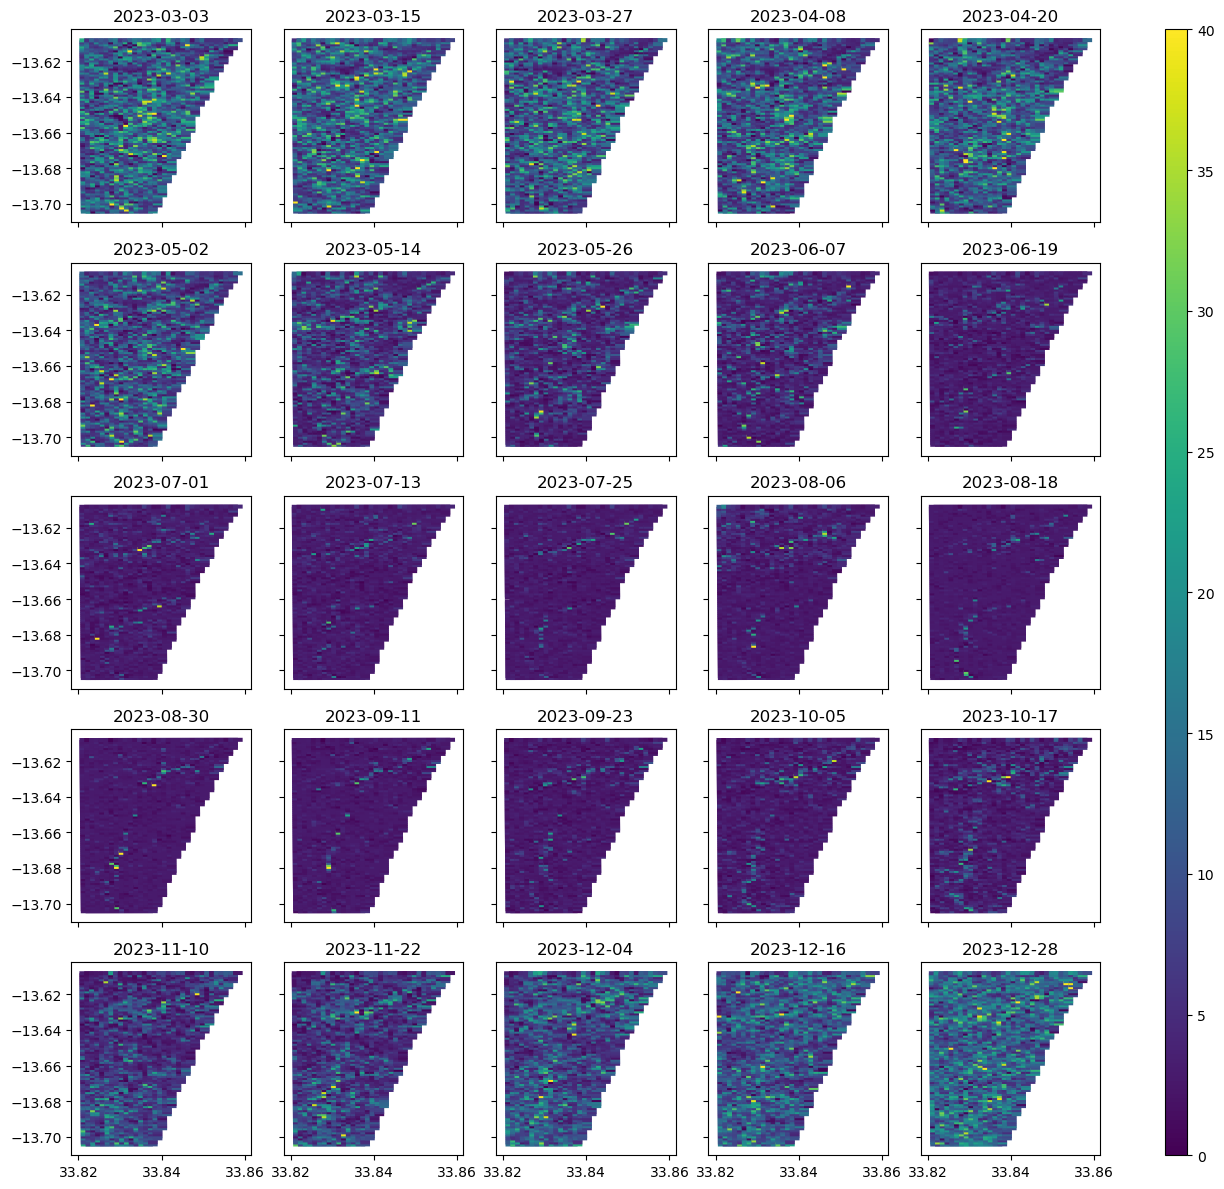

In [134]:

from matplotlib.colors import Normalize
import matplotlib.cm as cm
import datetime
cmap = cm.get_cmap('viridis')
normalizer = Normalize(0, 40)
im = cm.ScalarMappable(norm=normalizer)

fig, axs = plt.subplots(5,5, figsize=(14, 12), sharex=True, sharey=True)
for i, ax in enumerate(np.ravel(axs)):
    col = gdf.columns[i]
    gdf.plot(ax=ax, column = col, legend=False, cmap=cmap, norm=normalizer, aspect=None)
    col_date = datetime.datetime.strptime(col, "D%Y%m%d")
    ax.set_title(col_date.date())
plt.tight_layout()
fig.colorbar(im, ax=axs.ravel().tolist(), aspect=50)
plt.savefig(ssm_path/"all_date_compare.png")

In [5]:
df_datetimes = pd.to_datetime(gdf.columns[:-1], format="D%Y%m%d")

NameError: name 'gdf' is not defined

In [24]:
ERA5_data =  netCDF4.Dataset("malawi/SSM/malawi_InSAR_SSM_20240101_20240531/ERA5/03_2024_ssm.nc")

In [37]:
ERA5_data.variables.keys()

dict_keys(['longitude', 'latitude', 'time', 'tp', 'skt', 'swvl1'])

In [26]:
ERA5_data1 =  netCDF4.Dataset("malawi/SSM/malawi_InSAR_SSM/ERA5/03_2023_ssm.nc")

In [35]:
ERA5_data1.variables

(744, 5, 5)

In [7]:
for era_file in Path("malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5").glob("*[A-z].nc"):
    era_data = netCDF4.Dataset(era_file)
    print(era_file, era_data['swvl1'].shape)

malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/05_2024_ssm.nc (720, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/10_2023_ssm.nc (744, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/02_2024_ssm.nc (696, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2023_ssm.nc (720, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2024_ssm.nc (720, 2, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/11_2023_ssm.nc (720, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/06_2023_ssm.nc (720, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/02_2023_ssm.nc (672, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/07_2023_ssm.nc (744, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/01_2023_ssm.nc (744, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/08_2023_ssm.nc (744, 25, 29)
malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2024_ssm_new.nc

In [36]:
if era_data.dimensions.get("valid_time") is not None:
    print("HI")
else:
    print("oink")

HI


In [1]:
from pathlib import Path
import netCDF4

In [32]:
for era_file in Path("malawi/ERA5/kasungu").glob("*[A-z].nc"):
    
    with netCDF4.Dataset(era_file,'r') as era_data:
        # if era_data.dimensions.get("valid_time") is None:
        #     era_data.renameDimension("time","valid_time")
        print(era_file, era_data['swvl1'].shape)
        print(era_data.dimensions)
    

malawi/ERA5/kasungu/05_2024_ssm.nc (720, 8, 10)
{'valid_time': <class 'netCDF4._netCDF4.Dimension'>: name = 'valid_time', size = 720, 'latitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 8, 'longitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 10}
malawi/ERA5/kasungu/10_2023_ssm.nc (744, 8, 10)
{'valid_time': <class 'netCDF4._netCDF4.Dimension'>: name = 'valid_time', size = 744, 'latitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 8, 'longitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 10}
malawi/ERA5/kasungu/02_2024_ssm.nc (696, 8, 10)
{'valid_time': <class 'netCDF4._netCDF4.Dimension'>: name = 'valid_time', size = 696, 'latitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 8, 'longitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 10}
malawi/ERA5/kasungu/04_2023_ssm.nc (720, 8, 10)
{'valid_time': <class 'netCDF4._netCDF4.Dimension'>: name = 'valid_

In [17]:
Dl_datasets = [
    "malawi/ERA5/kasungu/01_2023_ssm.nc",
    "malawi/ERA5/kasungu/02_2023_ssm.nc",
    "malawi/ERA5/kasungu/03_2023_ssm.nc",
    "malawi/ERA5/kasungu/04_2023_ssm.nc",
    "malawi/ERA5/kasungu/05_2023_ssm.nc",
    "malawi/ERA5/kasungu/06_2023_ssm.nc",
    "malawi/ERA5/kasungu/07_2023_ssm.nc",
    "malawi/ERA5/kasungu/08_2023_ssm.nc",
    "malawi/ERA5/kasungu/09_2023_ssm.nc",
    "malawi/ERA5/kasungu/10_2023_ssm.nc",
    "malawi/ERA5/kasungu/11_2023_ssm.nc",
    "malawi/ERA5/kasungu/12_2023_ssm.nc",
    "malawi/ERA5/kasungu/01_2024_ssm.nc",
    "malawi/ERA5/kasungu/02_2024_ssm.nc",
    "malawi/ERA5/kasungu/03_2024_ssm.nc",
    "malawi/ERA5/kasungu/04_2024_ssm.nc",
    "malawi/ERA5/kasungu/05_2024_ssm.nc",
    "malawi/ERA5/kasungu/Last_day.nc",
]

In [20]:
era_data.dimensions

{'latitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 8,
 'longitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 10,
 'time': <class 'netCDF4._netCDF4.Dimension'>: name = 'valid_time', size = 720}

In [21]:
era_data.close()

In [28]:
beta_dl = "malawi/ERA5/kasungu/05_2024_ssm.nc"
orig_dl = "malawi/ERA5/05_2024_ssm.nc"
beta_era_data = netCDF4.Dataset(beta_dl)
orig_era_data = netCDF4.Dataset(orig_dl)

In [29]:
beta_era_data,orig_era_data

(<class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF4 data model, file format HDF5):
     GRIB_centre: ecmf
     GRIB_centreDescription: European Centre for Medium-Range Weather Forecasts
     GRIB_subCentre: 0
     Conventions: CF-1.7
     institution: European Centre for Medium-Range Weather Forecasts
     history: 2024-08-06T11:11 GRIB to CDM+CF via cfgrib-0.9.14.0/ecCodes-2.36.0 with {"source": "data.grib", "filter_by_keys": {}, "encode_cf": ["parameter", "time", "geography", "vertical"]}
     dimensions(sizes): valid_time(720), latitude(8), longitude(10)
     variables(dimensions): int64 number(), int64 valid_time(valid_time), float64 latitude(latitude), float64 longitude(longitude), <class 'str'> expver(valid_time), float32 tp(valid_time, latitude, longitude), float32 skt(valid_time, latitude, longitude), float32 swvl1(valid_time, latitude, longitude)
     groups: ,
 <class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
     Con

In [3]:
kasungu_era5 = sorted(list(Path("malawi/ERA5/kasungu").glob("*[A-z].nc")))
kasungu_era5

[PosixPath('malawi/ERA5/kasungu/01_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/01_2024_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/02_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/02_2024_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/03_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/03_2024_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/04_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/04_2024_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/05_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/05_2024_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/06_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/07_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/08_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/09_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/10_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/11_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/12_2023_ssm.nc'),
 PosixPath('malawi/ERA5/kasungu/Last_day.nc')]

In [4]:
import xarray as xr

In [25]:
ds = xr.open_mfdataset(kasungu_era5, combine='by_coords')

ValueError: unable to decode time units 'seconds since 1970-01-01' with "calendar 'proleptic_gregorian'". Try opening your dataset with decode_times=False or installing cftime if it is not installed.

In [24]:
import cftime

In [8]:
from insar4sm.prep_meteo import cftime_to_datetime
time_var=ERA5_data.variables["time"]
t_cal = ERA5_data.variables["time"].calendar
dtime = netCDF4.num2date(time_var[:],time_var.units, calendar = t_cal)                
dtime_datetime=[cftime_to_datetime(cfdatetime) for cfdatetime in dtime.data]

/tmp/ipykernel_4138045/1263800140.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  plt.plot(df_datetimes, gdf.dropna().mean(), '-o')


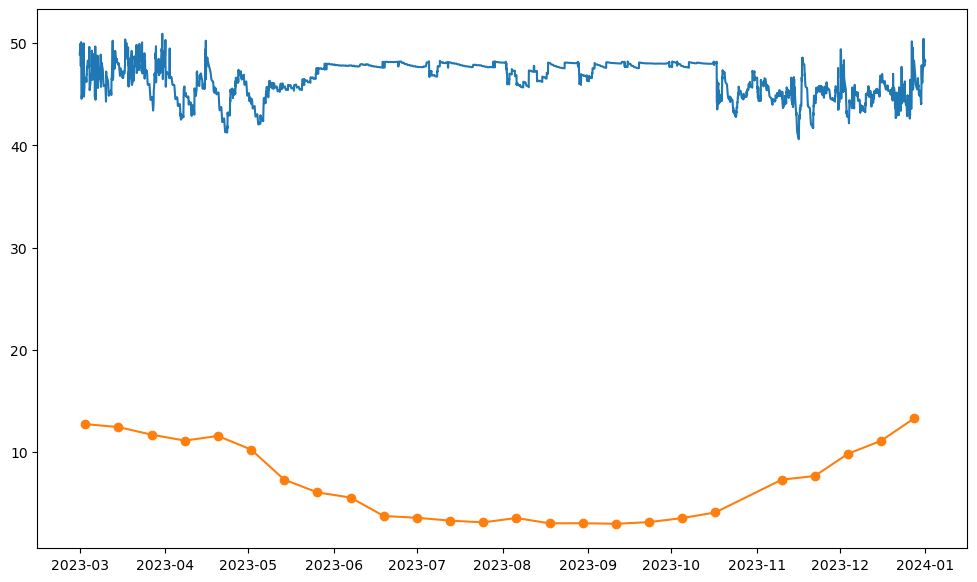

In [185]:
plt.figure(figsize=(12,7))
plt.plot(dtime_datetime, 100*ERA5_data.variables["swvl1"][:].mean(axis=(1,2)))
plt.plot(df_datetimes, gdf.dropna().mean(), '-o')

In [146]:
!pwd

/data/tapas/pearse


/data/tapas/pearse


In [5]:
bad_era_file = "malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/bad_era5/04_2024_ssm_bad.nc"
bad_era_data = netCDF4.Dataset(bad_era_file)
good_era_file = "malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2023_ssm.nc"
good_era_data = netCDF4.Dataset(good_era_file)
new_era_file = "malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2024_ssm_new.nc"
new_era_data = netCDF4.Dataset(new_era_file)


In [6]:
bad_era_data, good_era_data, new_era_data

(<class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
     Conventions: CF-1.6
     history: 2024-06-20 17:56:14 GMT by grib_to_netcdf-2.28.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data1/adaptor.mars.internal-1718906170.965583-16772-19-ee4ebf49-db45-4656-af95-aa6096d18630.nc /cache/tmp/ee4ebf49-db45-4656-af95-aa6096d18630-adaptor.mars.internal-1718905848.5250044-16772-13-tmp.grib
     dimensions(sizes): longitude(29), latitude(25), expver(2), time(720)
     variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), int32 expver(expver), int32 time(time), int16 tp(time, expver, latitude, longitude), int16 skt(time, expver, latitude, longitude), int16 swvl1(time, expver, latitude, longitude)
     groups: ,
 <class 'netCDF4._netCDF4.Dataset'>
 root group (NETCDF3_64BIT_OFFSET data model, file format NETCDF3):
     Conventions: CF-1.6
     history: 2024-06-20 15:32:19 GMT by grib_to_netcdf-2.28.1

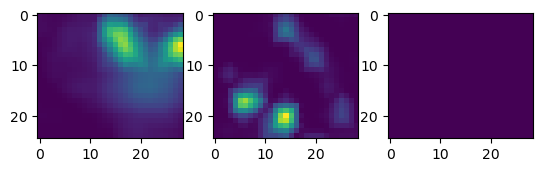

In [184]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(good_era_data['tp'][1])
ax[1].imshow(bad_era_data['tp'][1,1])
ax[2].imshow(new_era_data['tp'][1])

In [107]:
good_era_data.file_format, bad_era_data.file_format

('NETCDF3_64BIT_OFFSET', 'NETCDF3_64BIT_OFFSET')

In [179]:
good_era_data.dimensions, bad_era_data.dimensions, new_era_data.dimensions

({'longitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 29,
  'latitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 25,
  'time': <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 720},
 {'longitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 29,
  'latitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 25,
  'expver': <class 'netCDF4._netCDF4.Dimension'>: name = 'expver', size = 2,
  'time': <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 720},
 {'longitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'longitude', size = 29,
  'latitude': <class 'netCDF4._netCDF4.Dimension'>: name = 'latitude', size = 25,
  'time': <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 720})

In [180]:
good_era_data.variables['tp'], bad_era_data.variables['tp'], new_era_data.variables['tp']

(<class 'netCDF4._netCDF4.Variable'>
 int16 tp(time, latitude, longitude)
     scale_factor: 3.0092700958659427e-06
     add_offset: 0.09860174396114348
     _FillValue: -32767
     missing_value: -32767
     units: m
     long_name: Total precipitation
 unlimited dimensions: 
 current shape = (720, 25, 29)
 filling on,
 <class 'netCDF4._netCDF4.Variable'>
 int16 tp(time, expver, latitude, longitude)
     scale_factor: 3.339512734946281e-07
     add_offset: 0.010942247427324983
     _FillValue: -32767
     missing_value: -32767
     units: m
     long_name: Total precipitation
 unlimited dimensions: 
 current shape = (720, 2, 25, 29)
 filling on,
 <class 'netCDF4._netCDF4.Variable'>
 int16 tp(time, latitude, longitude)
     scale_factor: 3.339512734946281e-07
     add_offset: 0.010942247427324983
     _FillValue: -32767
     missing_value: -32767
     units: m
     long_name: Total precipitation
 unlimited dimensions: 
 current shape = (720, 25, 29)
 filling on)

### Fix bad ERA5 file
Update netCDF from https://stackoverflow.com/a/49592545

In [234]:
bad_era_file =  "malawi/SSM/malawi_InSAR_SSM_1km_southern_20230101_20230531/ERA5/04_2024_ssm.nc"
bad_era_data = netCDF4.Dataset(bad_era_file)
good_era_file = "malawi/SSM/malawi_InSAR_SSM_1km_southern_20230101_20230531/ERA5/04_2023_ssm.nc"
good_era_data = netCDF4.Dataset(good_era_file)
new_era_file = "malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2024_ssm_new.nc"
new_era_data = netCDF4.Dataset(new_era_file)


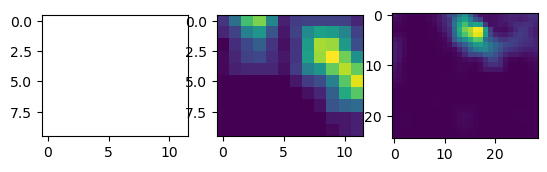

In [235]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(bad_era_data['tp'][100,0])
ax[1].imshow(bad_era_data['tp'][100,1])
ax[2].imshow(good_era_data['tp'][100])

In [233]:
import xarray as xr
Downloaded_datasets = ["malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2024_ssm_bad.nc","malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/03_2024_ssm.nc", "malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2023_ssm.nc"]
ds = xr.open_mfdataset(Downloaded_datasets, combine='by_coords')

ValueError: Every dimension needs a coordinate for inferring concatenation order

In [229]:
type(good_era_data['tp'])

netCDF4._netCDF4.Variable

Copying dimensions
Dimension:longitude
Dimension:latitude
Dimension:expver
Dimension:time
Copying variables
Variable: longitude, variable datatype: float32
Variable: latitude, variable datatype: float32
Variable: expver, variable datatype: int32
Variable: time, variable datatype: int32
Variable: tp, variable datatype: int16
<class 'netCDF4._netCDF4.Variable'>
float64 tp(time, latitude, longitude)
unlimited dimensions: 
current shape = (720, 25, 29)
filling on, default _FillValue of 9.969209968386869e+36 used
0.0018460826398783037 0.0018460826398783037
Variable: skt, variable datatype: int16
<class 'netCDF4._netCDF4.Variable'>
float64 skt(time, latitude, longitude)
unlimited dimensions: 
current shape = (720, 25, 29)
filling on, default _FillValue of 9.969209968386869e+36 used
302.25334924144846 302.25334924144846
Variable: swvl1, variable datatype: int16
<class 'netCDF4._netCDF4.Variable'>
float64 swvl1(time, latitude, longitude)
unlimited dimensions: 
current shape = (720, 25, 29)
fil

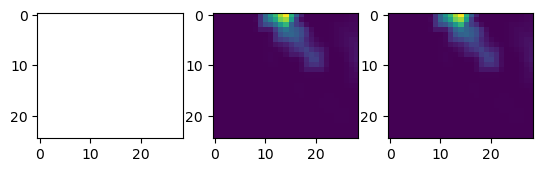

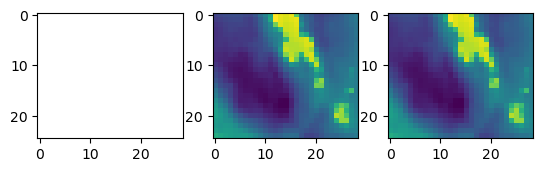

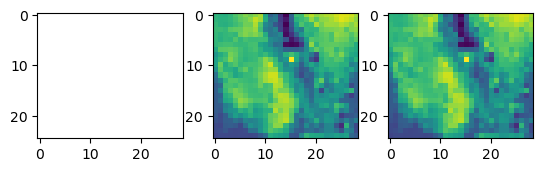

In [238]:
bad_era_file = "malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2024_ssm_bad.nc"
new_era_file = "malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2024_ssm_new.nc"
good_vars = ["longitude", "latitude", "time"]
with netCDF4.Dataset(new_era_file, 'w', format="NETCDF3_64BIT_OFFSET") as new_era, netCDF4.Dataset(bad_era_file) as bad_era:
    new_era.setncatts(bad_era.__dict__)
    print("Copying dimensions")
    for name, dimension in bad_era.dimensions.items():
        print(f"Dimension:{name}")
        if name != "expver":
            new_era.createDimension(
                name, (len(dimension) if not dimension.isunlimited() else None))
    print("Copying variables")
    for name, variable in bad_era.variables.items():
        print(f"Variable: {name}, variable datatype: {variable.datatype}")
        if name != "expver":
            x = new_era.createVariable(name, bad_era[name][:].dtype, tuple(dim for dim in variable.dimensions if dim !="expver"))
            if name in good_vars:
                new_era[name][:] = bad_era[name][:]
            else:

                print(new_era[name])
                new_era[name][:] = bad_era[name][:,1] # second dimension is ok, don't know why
                fig, ax = plt.subplots(1,3)
                ax[0].imshow(bad_era[name][100,0])
                ax[1].imshow(bad_era[name][100,1])
                ax[2].imshow(new_era[name][100])
                print(np.max(bad_era[name][100,1]), np.max(new_era[name][100]))
            # copy variable attributes all at once via dictionary
            new_era[name].setncatts(bad_era[name].__dict__)

In [267]:
good_era_file = "malawi/SSM/malawi_InSAR_SSM_20240101_20240531/ERA5/03_2024_ssm.nc"
new_era_file = "malawi/SSM/malawi_InSAR_SSM_20240101_20240531/ERA5/04_2024_ssm.nc"
new_era_data = netCDF4.Dataset(new_era_file)
good_era_data = netCDF4.Dataset(good_era_file)

In [277]:
good_era_data['time'], new_era_data['time']

(<class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (744,)
 filling on, default _FillValue of -2147483647 used,
 <class 'netCDF4._netCDF4.Variable'>
 int32 time(time)
     units: hours since 1900-01-01 00:00:00.0
     long_name: time
     calendar: gregorian
 unlimited dimensions: 
 current shape = (720,)
 filling on, default _FillValue of -2147483647 used)

## SSM code profiling

In [1]:
from insar4sm.prep_meteo import convert_to_df
aoi = "malawi/sentinel1/aoi/aoi.geojson"
meteo_df = convert_to_df("malawi/SSM/malawi_InSAR_SSM/ERA5/ERA5_20230301T000000_20231231T230000_-13.5_33.7_-13.9_34.1.nc", aoi, True)
meteo_df1 = convert_to_df("malawi/SSM/malawi_InSAR_SSM_20240101_20240531/ERA5/ERA5_20240101T000000_20240531T230000_-13.5_33.7_-13.9_34.1.nc", aoi, True)


In [2]:
len(meteo_df), len(meteo_df1)

(7344, 3648)

In [23]:
topstackDir = "/data/tapas/pearse/malawi/sentinel1/stack_full_frame"
# topstackDir1 = "/data/tapas/pearse/malawi/sentinel1/stack_20240101_20240531_IW3"
projectname = "malawi_InSAR_SSM_5km_20230101_20240531"
# projectname1 = "malawi_InSAR_SSM_20240101_20240531"
n_CPUs = 32
AOI = "/data/tapas/pearse/malawi/sentinel1/aoi/Malawi_frame_640_intersection1.geojson"
meteo_file = "/data/tapas/pearse/malawi/ERA5/ERA5_20230101T000000_20240531T230000_malawi_bbox.nc"
# meteo_file1 = "malawi/SSM/malawi_InSAR_SSM_20240101_20240531/ERA5/ERA5_20240101T000000_20240531T230000_-13.5_33.7_-13.9_34.1.nc"
ERA5_flag = True
sand_soilgrids = '/data/tapas/pearse/malawi/SSM/soilgrids/sand_0-5cm_mean_5000.tif'
clay_soilgrids = '/data/tapas/pearse/malawi/SSM/soilgrids/clay_0-5cm_mean_5000.tif'
orbit_time = "02:00:00"
export_dir = "/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_5km_20230101_20240531"


# export_dir1 = "/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_20240101_20240531"

In [3]:
from insar4sm.classes import INSAR4SM_stack, SM_point

In [24]:
grid_size = 500
stack = INSAR4SM_stack(topstackDir = topstackDir,
                       projectname = projectname,
                       n_CPUs = n_CPUs,
                       AOI = AOI,
                       meteo_file = meteo_file,
                       ERA5_flag = ERA5_flag,
                       sand = sand_soilgrids,
                       clay = clay_soilgrids,
                       orbit_time = orbit_time,
                       export_dir = export_dir)

stack.prepare_datasets()
stack.plot()
stack.get_dry_SARs()
stack.calc_insar_stack()
stack.calc_grid(grid_size = grid_size)

number of SLCs discovered:  40
directory "/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_5km_20230101_20240531/malawi_InSAR_SSM_5km_20230101_20240531/INSAR4SM_datasets/slcs" already exists.
write vrt file for each SLC ...
stack directory: /data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_5km_20230101_20240531/malawi_InSAR_SSM_5km_20230101_20240531/INSAR4SM_datasets/coreg_stack already exists
write vrt file for stack directory
directory /data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_5km_20230101_20240531/malawi_InSAR_SSM_5km_20230101_20240531/INSAR4SM_datasets/geometry already exists.
write vrt file for geometry dataset


In [26]:
stack.slc_stack

array([[[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]],

       [[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
        ...,
        [0.+

In [7]:
import time
start_time = time.time()
sm_ind= 0
sm_point_ts = SM_point(stack, sm_ind)
sm_point_ts.amp_sel = True
sm_point_ts.get_DS_info(stack)
sm_point_ts.calc_covar_matrix()
if sm_point_ts.non_coverage or np.all(sm_point_ts.amp_DS==0):
    # return np.full(sm_point_ts.n_ifg, np.nan)
    print("oops")
else:
    get_DS_geometry_start_time = time.time()
    sm_point_ts.get_DS_geometry(stack)
    get_DS_geometry_time = time.time() - get_DS_geometry_start_time
    print(f"Time for get_DS_geometry: {get_DS_geometry_time} s")

    calc_driest_date_start_time = time.time()
    sm_point_ts.calc_driest_date()
    calc_driest_date_time = time.time() - calc_driest_date_start_time
    print(f"Time for calc_driest_date: {calc_driest_date_time} s")
    # if dry_date_manual_flag: sm_point_ts.driest_date = pd.to_datetime(dry_date)
    calc_sm_sorting_start_time = time.time()
    sm_point_ts.calc_sm_sorting()
    calc_sm_sorting_time = time.time() - calc_sm_sorting_start_time
    print(f"Time for calc_sm_sorting: {calc_sm_sorting_time} s")
    
    calc_sm_coherence_start_time = time.time()
    sm_point_ts.calc_sm_coherence()
    calc_sm_coherence_time = time.time() - calc_sm_coherence_start_time
    print(f"Time for calc_sm_coherence: {calc_sm_coherence_time} s")
    
    calc_sm_index_start_time = time.time()
    sm_point_ts.calc_sm_index()
    calc_sm_index_time = time.time() - calc_sm_index_start_time
    print(f"Time for calc_sm_index: {calc_sm_index_time} s")
    
    inversion_start_time = time.time()
    sm_point_ts.inversion()
    inversion_time = time.time() - inversion_start_time
    print(f"Time for inversion: {inversion_time} s")

Time for get_DS_geometry: 0.690838098526001 s
Time for calc_driest_date: 0.0006666183471679688 s
Time for calc_sm_sorting: 1.5068185329437256 s
Time for calc_sm_coherence: 0.020035505294799805 s
Time for calc_sm_index: 36.15971875190735 s
Time for inversion: 252.23141241073608 s


In [13]:
import pstats, cProfile

In [14]:
cProfile.runctx("sm_point_ts.inversion()", globals(), locals(), "Profile.prof")

s = pstats.Stats("Profile.prof")
s.strip_dirs().sort_stats("time").print_stats()

Fri Jun 14 12:08:42 2024    Profile.prof

         87910488 function calls (84351808 primitive calls) in 271.725 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
      460   84.295    0.183  160.907    0.350 phase_closure_funcs.py:17(Covar_2_phase_closures)
  9874620   72.836    0.000   72.836    0.000 {method 'index' of 'list' objects}
  1777860   41.120    0.000   92.150    0.000 dielectic_models.py:3(hallikainen_1985_calc)
 14238108   38.771    0.000   38.771    0.000 {built-in method numpy.array}
  1777860   11.086    0.000  105.933    0.000 forward_modelling_funcs.py:7(vertical_wavenumber_calc)
9209103/5650426    3.722    0.000   14.526    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
  3555720    2.923    0.000    2.923    0.000 {built-in method numpy.core._multiarray_umath.interp}
  3555720    2.571    0.000    9.915    0.000 function_base.py:1432(interp)
   888930    2.500    0.000  10

In [16]:
# cProfile.run("sm_point_ts.calc_sm_index()")
cProfile.runctx("sm_point_ts.calc_sm_index()", globals(), locals(), "Profile_calc_sm_index.prof")

s = pstats.Stats("Profile_calc_sm_index.prof")
s.strip_dirs().sort_stats("time").print_stats()

Fri Jun 14 13:07:18 2024    Profile_calc_sm_index.prof

         518808 function calls (502953 primitive calls) in 38.636 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    15022   38.275    0.003   38.288    0.003 calc_SM_index.py:12(calc_coh_model)
      406    0.059    0.000   37.557    0.093 _numdiff.py:566(_dense_difference)
64647/48793    0.042    0.000    0.156    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
    15022    0.037    0.000    0.071    0.000 linalg.py:2349(norm)
    15022    0.036    0.000   38.410    0.003 calc_SM_index.py:155(objective_function)
    15022    0.021    0.000   38.461    0.003 _differentiable_functions.py:132(fun_wrapped)
    15835    0.016    0.000    0.034    0.000 shape_base.py:23(atleast_1d)
    15439    0.013    0.000    0.013    0.000 {built-in method numpy.zeros}
    14616    0.013    0.000   37.495    0.003 _numdiff.py:455(fun_wrapped)
    15028   

In [12]:
sm_point_ts.slc_dates.shape

(36,)

In [28]:
sm_point_ts1 = SM_point(stack1, sm_ind)
sm_point_ts1.amp_sel = True
sm_point_ts1.get_DS_info(stack1)
sm_point_ts1.calc_covar_matrix()
if sm_point_ts1.non_coverage or np.all(sm_point_ts1.amp_DS==0):
    # return np.full(sm_point_ts1.n_ifg, np.nan)
    print("oops")
else:
    sm_point_ts1.get_DS_geometry(stack1)
    sm_point_ts1.calc_driest_date()
    # if dry_date_manual_flag: sm_point_ts1.driest_date = pd.to_datetime(dry_date)
    sm_point_ts1.calc_sm_sorting()
    sm_point_ts1.calc_sm_coherence()
    sm_point_ts1.calc_sm_index()
    sm_point_ts1.inversion()

TypeError: The number of func parameters=3 must not exceed the number of data points=2

In [ ]:
from __future__ import annotations
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from collections import Counter

In [87]:
Datetimes = sm_point_ts.slc_dates
SM_sorting = sm_point_ts.best_sorting
n_bands = sm_point_ts.nbands
n_ds = sm_point_ts.n_ds
ind_DS = sm_point_ts.DS_ind
coh_full_DS = sm_point_ts.coh_full_DS
band_start = sm_point_ts.start_index
band_end = sm_point_ts.end_index
n_dry_bands = sm_point_ts.n_dry_bands
max_coh_flag = sm_point_ts.max_coh_flag
simple_exp_model = sm_point_ts.simple_exp_model


In [89]:
Datetimes = sm_point_ts1.slc_dates
SM_sorting = sm_point_ts1.best_sorting
n_bands = sm_point_ts1.nbands
n_ds = sm_point_ts1.n_ds
ind_DS = sm_point_ts1.DS_ind
coh_full_DS = sm_point_ts1.coh_full_DS
band_start = sm_point_ts1.start_index
band_end = sm_point_ts1.end_index
n_dry_bands = sm_point_ts1.n_dry_bands
max_coh_flag = sm_point_ts1.max_coh_flag
simple_exp_model = sm_point_ts1.simple_exp_model


In [84]:
Datetimes = Datetimes[band_start:band_end].copy()
coh = coh_full_DS[ind_DS,band_start:band_end,band_start:band_end].copy()
coh[np.diag_indices_from(coh)] = np.nan
dry_bands_inds = SM_sorting[:n_dry_bands].copy()

In [78]:
coh_dry = coh[dry_bands_inds,:][:, dry_bands_inds].copy()
bad_dry_bands = (coh_dry<np.nanquantile(coh_dry.flatten(), 0.1)).nonzero()[0]
drop_dry_bands = [item for item, count in Counter(bad_dry_bands).items() if count > 1]
drop_dry_bands_inds = SM_sorting[drop_dry_bands]
drop_dry_bands_indices=np.argwhere(np.isin(dry_bands_inds , drop_dry_bands_inds))
dry_bands_inds=np.delete(dry_bands_inds,drop_dry_bands_indices)

In [90]:
n_dry_bands

3

: 

In [65]:
    # update the number of dry bands
n_dry_bands = dry_bands_inds.shape[0]

# update the dry coherence matrix
coh_dry = coh[dry_bands_inds,:][:, dry_bands_inds].copy()

# select only the upper triangular elements
num_tri_elements = np.triu_indices_from(coh_dry,1)[0].shape[0]
num_tri_indices = np.triu_indices_from(coh_dry,1)
indices1 = num_tri_indices[0]
indices2 = num_tri_indices[1]

# Get the temporal infrormation of dry bands
dry_datetimes = Datetimes[dry_bands_inds]

array([10, 11,  8], dtype=int32)

In [66]:
coh_sm_mean = np.zeros((n_ds,n_bands), dtype=np.float32)
coh_sm_std = np.zeros((n_ds,n_bands), dtype=np.float32)
coh_sm = np.zeros((n_ds,n_bands,n_bands), dtype=np.float32)
coh_decor = np.full((n_bands, n_bands), np.nan, dtype=np.float64)

# get the coherence values for each time combination of dry dates
Dt = np.array([np.abs((dry_datetimes[indices2[int_n]]-dry_datetimes[indices1[int_n]]).days) for int_n in range(num_tri_elements)])
Permanent_Cohs = np.asarray(coh_dry[num_tri_indices])

# select the maximum coherence values for each time combination
coh_time_df = pd.DataFrame(np.array([Dt,Permanent_Cohs])).T
max_coh_time_df = coh_time_df.groupby([0]).max()
Dt_max = max_coh_time_df.index.values
Permanent_max_Cohs = max_coh_time_df[1].values

In [40]:
from insar4sm.coh_funcs import temp_coh__model

In [174]:
if simple_exp_model: # simple exponential model
    if max_coh_flag:
        fit = curve_fit(exp_fit, Dt_max, Permanent_max_Cohs)
        a, b = fit[0]
        gamma_t_modelled= exp_fit(Dt, a, b)
    else:
        fit = curve_fit(exp_fit, Dt.astype(dtype=np.float128), Permanent_Cohs.astype(dtype=np.float128))
        a, b = fit[0]
        gamma_t_modelled= exp_fit(Dt, a, b)
else: # Parizzi`s exponential model
    if max_coh_flag:
        try:
            # import pdb
            # pdb.set_trace()
            fit = curve_fit(temp_coh__model, Dt_max, Permanent_max_Cohs, maxfev = 2000)
            gamma_0, tau, gamma_k = fit[0]
            gamma_t_modelled = temp_coh__model(Dt, gamma_0, tau, gamma_k)
        except RuntimeError:
            print("Coherence loss due to temporal decorrelation cannot be estimated!")
            coh_sm[ind_DS, :, :]  = coh
            coh_sm_dry = coh_sm[ind_DS, dry_bands_inds,:].copy()
            coh_sm_mean[ind_DS,:] = np.nanmean(coh_sm_dry, axis=0)
            coh_sm_std[ind_DS,:] = np.nanstd(coh_sm_dry, axis=0)
            # return coh_sm, coh_sm_mean, coh_sm_std
    else:
        fit = curve_fit(temp_coh__model, Dt, Permanent_Cohs, maxfev = 2000)
        gamma_0, tau, gamma_k = fit[0]
        gamma_t_modelled = temp_coh__model(Dt, gamma_0, tau, gamma_k)

TypeError: The number of func parameters=3 must not exceed the number of data points=2

In [47]:
Dt_max, Permanent_max_Cohs

(array([24., 48.]), array([0.28764433, 0.1786616 ]))

In [262]:
coh_time_df #physics, school of natural sciences, Uni of Galway

,0,1
0,12.0,0.837473
1,36.0,0.667200
2,48.0,0.624443
3,24.0,0.742544
4,12.0,0.724666
5,24.0,0.709749
6,36.0,0.701469
7,12.0,0.794863
8,24.0,0.676555
9,12.0,0.792386


In [252]:
stack1 = INSAR4SM_stack(topstackDir = "/data/tapas/pearse/malawi/sentinel1/stack_short",
                       projectname = "malawi_InSAR_SSM_short",
                       n_CPUs = n_CPUs,
                       AOI = AOI,
                       meteo_file = "/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM/ERA5/ERA5_20230301T000000_20231231T230000_-13.5_33.7_-13.9_34.1.nc",
                       ERA5_flag = ERA5_flag,
                       sand = sand_soilgrids,
                       clay = clay_soilgrids,
                       orbit_time = orbit_time,
                       export_dir = "/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_short")

stack1.prepare_datasets()
stack1.plot()
stack1.get_dry_SARs()
stack1.calc_insar_stack()
stack1.calc_grid(grid_size = grid_size)

number of SLCs discovered:  25
directory "/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_short/malawi_InSAR_SSM_short/INSAR4SM_datasets/slcs" already exists.
write vrt file for each SLC ...
stack directory: /data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_short/malawi_InSAR_SSM_short/INSAR4SM_datasets/coreg_stack already exists
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Topstack region
We will modify your AOI...
It seems that you AOI is outside of Tops

# Troubleshooting

In [1]:
from insar4sm.prep_meteo import convert_to_df
from insar4sm.meteo_funcs import find_dry_SARs

In [2]:
aoi0 = "malawi/sentinel1/aoi/dzakela_aoi_bigger.geojson"
aoi1 = "malawi/sentinel1/aoi/southern_malawi_aoi.geojson"

In [1]:
meteo_df0 = convert_to_df("malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/ERA5_20230101T000000_20240531T230000_-13.4_33.6_-13.9_34.2.nc.old", aoi0, True)
meteo_df1 = convert_to_df("malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/ERA5_20230101T000000_20240531T230000_-13.4_33.6_-13.9_34.2.nc", aoi0, True)

NameError: name 'convert_to_df' is not defined

In [290]:
meteo_df0.head(), meteo_df1.head()

(                              Datetimes  ...  swvl1__m**3 m**-3
 Datetimes                                ...                   
 2023-01-01 00:00:00 2023-01-01 00:00:00  ...           0.474548
 2023-01-01 01:00:00 2023-01-01 01:00:00  ...           0.473692
 2023-01-01 02:00:00 2023-01-01 02:00:00  ...           0.472256
 2023-01-01 03:00:00 2023-01-01 03:00:00  ...           0.470980
 2023-01-01 04:00:00 2023-01-01 04:00:00  ...           0.469834
 
 [5 rows x 4 columns],
                               Datetimes  tp__m  skt__K  swvl1__m**3 m**-3
 Datetimes                                                                
 2023-01-01 00:00:00 2023-01-01 00:00:00    NaN     NaN                NaN
 2023-01-01 01:00:00 2023-01-01 01:00:00    NaN     NaN                NaN
 2023-01-01 02:00:00 2023-01-01 02:00:00    NaN     NaN                NaN
 2023-01-01 03:00:00 2023-01-01 03:00:00    NaN     NaN                NaN
 2023-01-01 04:00:00 2023-01-01 04:00:00    NaN     NaN               

In [269]:
meteo_file1 = "/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_1km_southern_20230101_20230531/ERA5/04_2024_ssm.nc"
ERA5_data1=netCDF4.Dataset(meteo_file1)
meteo_file = "/data/tapas/pearse/malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/04_2024_ssm_bad.nc"
ERA5_data=netCDF4.Dataset(meteo_file)

In [270]:
ERA5_data['tp'],ERA5_data1['tp']

(<class 'netCDF4._netCDF4.Variable'>
 int16 tp(time, expver, latitude, longitude)
     scale_factor: 3.339512734946281e-07
     add_offset: 0.010942247427324983
     _FillValue: -32767
     missing_value: -32767
     units: m
     long_name: Total precipitation
 unlimited dimensions: 
 current shape = (720, 2, 25, 29)
 filling on,
 <class 'netCDF4._netCDF4.Variable'>
 float64 tp(time, latitude, longitude)
     scale_factor: 3.339512734946281e-07
     add_offset: 0.010942247427324983
     _FillValue: -32767
     missing_value: -32767
     units: m
     long_name: Total precipitation
 unlimited dimensions: 
 current shape = (720, 25, 29)
 filling on)

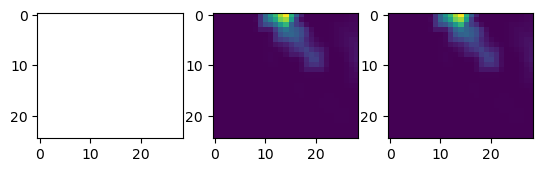

In [275]:
fig, ax = plt.subplots(1,3)
ax[0].imshow(ERA5_data["tp"][:,0][100])
ax[1].imshow(ERA5_data["tp"][:,1][100])
ax[2].imshow(ERA5_data1["tp"][:][100])

In [292]:
import netCDF4
from pathlib import Path

north_ncs = Path("malawi/SSM/malawi_InSAR_SSM_1km_20230101_20230531/ERA5/").glob("*.nc*")
south_ncs = Path("malawi/SSM/malawi_InSAR_SSM_1km_southern_20230101_20230531/ERA5/").glob("*ssm.nc")
north_ncs = sorted(north_ncs)
south_ncs = sorted(south_ncs)
for north in north_ncs:
    print(north.name)
    # meteo_dfN = convert_to_df(north, aoi0, True)
    # meteo_dfS = convert_to_df(south, aoi1, True)
    ERA5_dataN = netCDF4.Dataset(north)
    # ERA5_dataS = netCDF4.Dataset(south)
    lat0N, lat1N, lon0N, lon1N = np.min(ERA5_dataN["latitude"][:]), np.max(ERA5_dataN["latitude"][:]),np.min(ERA5_dataN["longitude"][:]), np.max(ERA5_dataN["longitude"][:])
    lat0S, lat1S, lon0S, lon1S = np.min(ERA5_dataS["latitude"][:]), np.max(ERA5_dataS["latitude"][:]),np.min(ERA5_dataS["longitude"][:]), np.max(ERA5_dataS["longitude"][:])
    N_bounds = (lon0N, lat0N, lon1N, lat1N)
    S_bounds = (lon0S, lat0S, lon1S, lat1S)
    # print(f"North bounds: {N_bounds}, South bounds: {S_bounds}")
    print(ERA5_dataN["tp"][:].mask.sum())#,ERA5_dataS["tp"][:].mask.sum())



01_2023_ssm.nc
0
01_2024_ssm.nc
0
02_2023_ssm.nc
0
02_2024_ssm.nc
0
03_2023_ssm.nc
0
03_2024_ssm.nc
0
04_2023_ssm.nc
0
04_2024_ssm.nc
0
04_2024_ssm_new.nc
0
05_2023_ssm.nc
0
05_2024_ssm.nc
0
06_2023_ssm.nc
0
07_2023_ssm.nc
0
08_2023_ssm.nc
0
09_2023_ssm.nc
0
10_2023_ssm.nc
0
11_2023_ssm.nc
0
12_2023_ssm.nc
0
ERA5_20230101T000000_20240531T230000_-13.4_33.6_-13.9_34.2.nc.old
725
Last_day.nc
0


In [63]:
from insar4sm.download_ERA5_land import Get_ERA5_data

In [ ]:
(34.761, -15.5356, 35.5257, -14.9102)
(33.72, -13.8, 34.015, -13.51)

In [29]:
import numpy as np

In [30]:
np.min(ERA5_data0["latitude"][:]), np.max(ERA5_data0["latitude"][:])

(-15.7, -13.3)

In [31]:
np.min(ERA5_data1["latitude"][:]), np.max(ERA5_data1["latitude"][:])

(-15.7, -13.3)

In [32]:
np.min(ERA5_data0["longitude"][:]), np.max(ERA5_data0["longitude"][:])

(33.2, 36.0)

In [33]:
np.min(ERA5_data1["longitude"][:]), np.max(ERA5_data1["longitude"][:])

(33.2, 36.0)

In [15]:
from pathlib import Path
import xarray as xr

In [16]:
Downloaded_datasets = Path("malawi/ERA5").glob("*nc")

In [17]:
Downloaded_datasets = sorted(list(Downloaded_datasets))

In [69]:
ds = xr.open_mfdataset(Downloaded_datasets, combine='by_coords')
for dvar in ds.data_vars:
    ds[dvar] = ds[dvar][:,:,:,1]
ds = ds.drop_dims("expver")

In [70]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 29, latitude: 25, time: 12408)
Coordinates:
  * longitude  (longitude) float32 33.2 33.3 33.4 33.5 ... 35.7 35.8 35.9 36.0
  * latitude   (latitude) float32 -13.3 -13.4 -13.5 -13.6 ... -15.5 -15.6 -15.7
  * time       (time) datetime64[ns] 2023-01-01 ... 2024-05-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 29), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 29), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 29), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-26 09:58:02 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [47]:
tp = ds['tp'].to_numpy()[:,0,0,:]

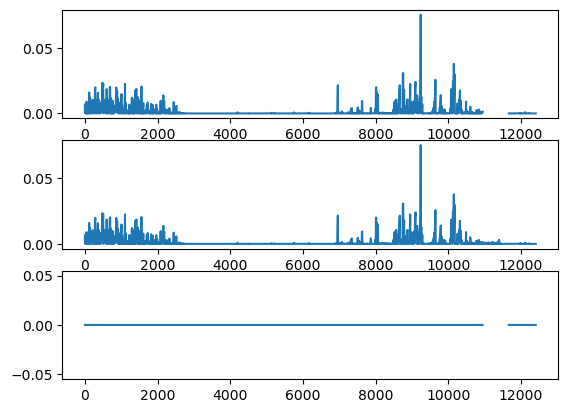

In [51]:

fig,ax = plt.subplots(3,1)
ax[0].plot(tp[:,0])
ax[1].plot(tp[:,1])
ax[2].plot(tp[:,1]-tp[:,0])

In [68]:
ds

<xarray.Dataset>
Dimensions:    (expver: 2, longitude: 29, latitude: 25, time: 12408)
Coordinates:
  * expver     (expver) int32 1 5
  * longitude  (longitude) float32 33.2 33.3 33.4 33.5 ... 35.7 35.8 35.9 36.0
  * latitude   (latitude) float32 -13.3 -13.4 -13.5 -13.6 ... -15.5 -15.6 -15.7
  * time       (time) datetime64[ns] 2023-01-01 ... 2024-05-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 29), meta=np.ndarray>
    skt        (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 29), meta=np.ndarray>
    swvl1      (time, latitude, longitude) float32 dask.array<chunksize=(744, 25, 29), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-06-26 09:58:02 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...

In [71]:
ds.to_netcdf("malawi/ERA5/ERA5_20230101T000000_20240531T230000_malawi_bbox.nc")

In [72]:
from insar4sm.prep_meteo import convert_to_df
meteo_df = convert_to_df("malawi/ERA5/ERA5_20230101T000000_20240531T230000_malawi_bbox.nc", "malawi/sentinel1/aoi/dzakela_aoi_bigger.geojson", True)

/data/tapas/pearse/insar4sm_dev/INSAR4SM/insar4sm/prep_meteo.py:47: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  p_lon = gpd.read_file(SM_AOI)['geometry'].centroid[0].x
/data/tapas/pearse/insar4sm_dev/INSAR4SM/insar4sm/prep_meteo.py:48: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  p_lat = gpd.read_file(SM_AOI)['geometry'].centroid[0].y


In [73]:
meteo_df

,Datetimes,tp__m,skt__K,swvl1__m**3 m**-3
Datetimes,,,,
2023-01-01 00:00:00,2023-01-01 00:00:00,0.009699,290.793329,0.482088
2023-01-01 01:00:00,2023-01-01 01:00:00,0.000001,290.711370,0.481049
2023-01-01 02:00:00,2023-01-01 02:00:00,0.000007,290.906134,0.480148
2023-01-01 03:00:00,2023-01-01 03:00:00,0.000019,290.940945,0.479384
2023-01-01 04:00:00,2023-01-01 04:00:00,0.000114,290.982366,0.479368
...,...,...,...,...
2024-05-31 19:00:00,2024-05-31 19:00:00,0.000000,315.430605,0.223620
2024-05-31 20:00:00,2024-05-31 20:00:00,0.000000,314.048305,0.223650
2024-05-31 21:00:00,2024-05-31 21:00:00,0.000000,313.069635,0.223650
